In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gp
import rioxarray
import dask
from os.path import isfile
from dask.distributed import Queue

dask.config.set({'array.slicing.split_large_chunks': False})

### Dask (cluster)

In [3]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster(cores=1, resource_spec='pmem=20GB', memory='20GB', walltime='00:30:00')

In [3]:
# print(cluster.job_script())

In [4]:
cluster.scale(jobs=30)  # ask for jobs

In [5]:
from dask.distributed import Client
client = Client(cluster)

In [6]:
client

Connection method: Cluster object,Cluster type: PBSCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.102.201.236:46385,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


### Function definitions

In [ ]:
# Get unique fips codes
def get_unique_fips():
    yield_path = '../data/processed/yields/'

    ufips = np.array([])
    for crop in ['corn', 'cotton', 'soy', 'rice', 'sorghum', 'barley', 'spring_wheat', 'winter_wheat']:
        tmp = pd.read_csv(yield_path + crop + '_all.csv')
        tmp['fips'] = tmp['fips'].astype(str).str.zfill(5)
        ufips = np.append(ufips, tmp['fips'].unique())
    
    ufips = np.unique(ufips)
    
    return ufips

In [ ]:
def get_avg_raster(fips):
    out_path = '/gpfs/group/kaf26/default/dcl5300/cropland_data_layer/county_weights/'
    
    if isfile(out_path + fips + '_08-20.nc'):
        return fips
    else:
        try:
            rio_years = []
    
            for year in range(2008, 2010):
                # Access Cropscape Data Layer
                tmp_rio = rioxarray.open_rasterio('https://nassgeodata.gmu.edu/webservice/nass_data_cache/byfips/CDL_' + str(year) + '_' + fips + '.tif')
                # Drop 'bands'
                tmp_rio = tmp_rio.squeeze(drop=True)
                # Assign year
                tmp_rio = tmp_rio.assign_coords({'time':year})
                tmp_rio = tmp_rio.expand_dims('time')
                rio_years.append(tmp_rio)
    
            # Combine along time dimension
            rio = xr.combine_by_coords(rio_years, combine_attrs='drop')
    
            # Select crops
            rio_crops = vec_isin(rio, crop_codes)
    
            # Get mean in lat/lon
            rio_crops = rio_crops.mean(dim = 'time').rio.reproject("epsg:4326", nodata=np.NaN)
    
            # Store
            ds = xr.Dataset({'cropland_avg' : rio_crops})
            ds.to_netcdf(out_path + fips + '_08-20.nc')
    
            return fips
        except Exception:
            pass

In [ ]:
# Vector function for checking crops
def vec_isin(a, b):
    return xr.apply_ufunc(np.isin, a, b)

## Weights based on CDL

In [2]:
# See https://www.nass.usda.gov/Research_and_Science/Cropland/sarsfaqs2.php
rio_crs = '+proj=aea +lat_0=23 +lon_0=-96 +lat_1=29.5 +lat_2=45.5 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs=True'

In [3]:
# Select crops (August 8th 2021 via https://www.nass.usda.gov/Research_and_Science/Cropland/docs/cdl_codes_names.xlsx)
crop_codes = [1, 2, 3, 4, 5, 21, 23, 24]

In [6]:
ufips = get_unique_fips()

In [13]:
# Parallelize downloads with dask
delayed_fips = []
for fips in ufips:
    tmp_fips = dask.delayed(get_avg_raster)(fips)
    delayed_fips.append(tmp_fips)

In [ ]:
# Run all
out_fips = dask.compute(*delayed_fips)

In [29]:
# Check missing
out_path = '/gpfs/group/kaf26/default/dcl5300/cropland_data_layer/county_weights/'
missing = []
for fips in ufips:
    if isfile(out_path + fips + '_08-20.nc'):
        continue
    else:
        missing.append(fips)

In [30]:
# These have either changed fips codes or there is no CDL data: neglect
missing

['04019', '29193', '32025', '46131', '51123']

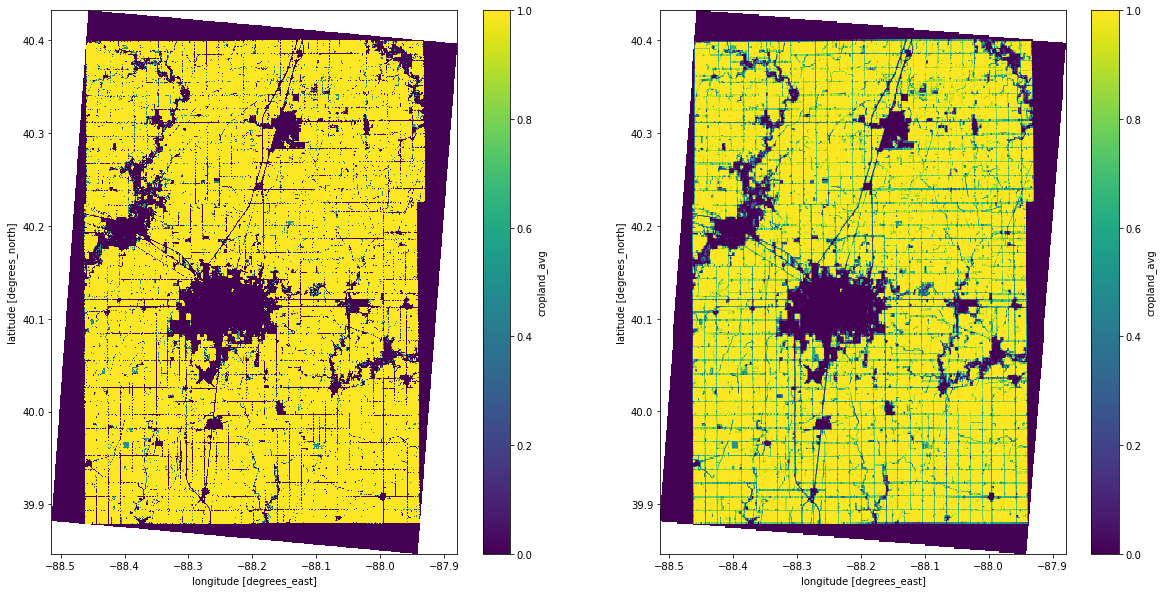

In [30]:
# Raster plots
import matplotlib.pyplot as plt

fips = '17019'
ds_weights = xr.open_dataset(weights_path + fips + '_08-20.nc')

fig, ax = plt.subplots(1,2, figsize=(20,10))

ds_weights['cropland_avg'].plot(ax=ax[0])
ds_weights.coarsen(x=5,y=5, boundary='pad').mean()['cropland_avg'].plot(ax=ax[1])

plt.show()

In [29]:
# Check aggregation
fips = '17019'

gdf = gp.read_file('/storage/work/dcl5300/bcsd_maize_scripts/tools/plotting_tools/counties_contig_plot.shp')
gdf = gdf.to_crs('WGS 84')
gdf_fips = gdf.query('fips == "' + fips + '"')
xmin, ymin, xmax, ymax = gdf_fips.geometry.total_bounds

# Predictor vars
ds = xr.open_dataset('/gpfs/group/kaf26/default/dcl5300/LOCA_VIC_soilMoisture/Livneh/Livneh_VIC_maize_quantile_predictors.nc')
ds = ds.where((ds.lat >= ymin) & (ds.lat <= ymax) & (ds.lon >= xmin) & (ds.lon <= xmax), drop=True)

# Read in weights
ds_weights = xr.open_dataset(weights_path + fips + '_08-20.nc')
ds_weights_coarse = ds_weights.coarsen(x=5, y=5, boundary='pad').mean()

# Aggregate
weightmap = xa.pixel_overlaps(ds , gdf_fips, weights = ds_weights.cropland_avg)
aggregated = xa.aggregate(ds, weightmap).to_dataset().to_dataframe().reset_index().drop(columns = ['pix_idx'])
aggregated['year'] = aggregated['time'].dt.year
aggregated.drop(columns = ['time'], inplace=True)

weightmap_coarse = xa.pixel_overlaps(ds , gdf_fips, weights = ds_weights_coarse.cropland_avg)
aggregated_coarse = xa.aggregate(ds, weightmap_coarse).to_dataset().to_dataframe().reset_index().drop(columns = ['pix_idx'])
aggregated_coarse['year'] = aggregated_coarse['time'].dt.year
aggregated_coarse.drop(columns = ['time'], inplace=True)

creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.
regridding weights to data grid...


/storage/work/dcl5300/ENVS/cropswitching/lib/python3.9/site-packages/xarray/core/dataarray.py:789: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/storage/work/dcl5300/ENVS/cropswitching/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/storage/work/dcl5300/ENVS/cropswitching/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


calculating overlaps between pixels and output polygons...


/storage/work/dcl5300/ENVS/cropswitching/lib/python3.9/site-packages/xarray/core/dataarray.py:789: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/storage/work/dcl5300/ENVS/cropswitching/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/storage/work/dcl5300/ENVS/cropswitching/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


success!
aggregating EDD...
aggregating GDD...
aggregating prcp...
aggregating EDD_SM_vdry...
aggregating EDD_SM_dry...
aggregating EDD_SM_med...
aggregating EDD_SM_wet...
aggregating EDD_SM_vwet...
aggregating SM_mean...
all variables aggregated to polygons!
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.
regridding weights to data grid...
calculating overlaps between pixels and output polygons...
success!
aggregating EDD...
aggregating GDD...
aggregating prcp...
aggregating EDD_SM_vdry...
aggregating EDD_SM_dry...
aggregating EDD_SM_med...
aggregating EDD_SM_wet...
aggregating EDD_SM_vwet...
aggregating SM_mean...
all variables aggregated to polygons!


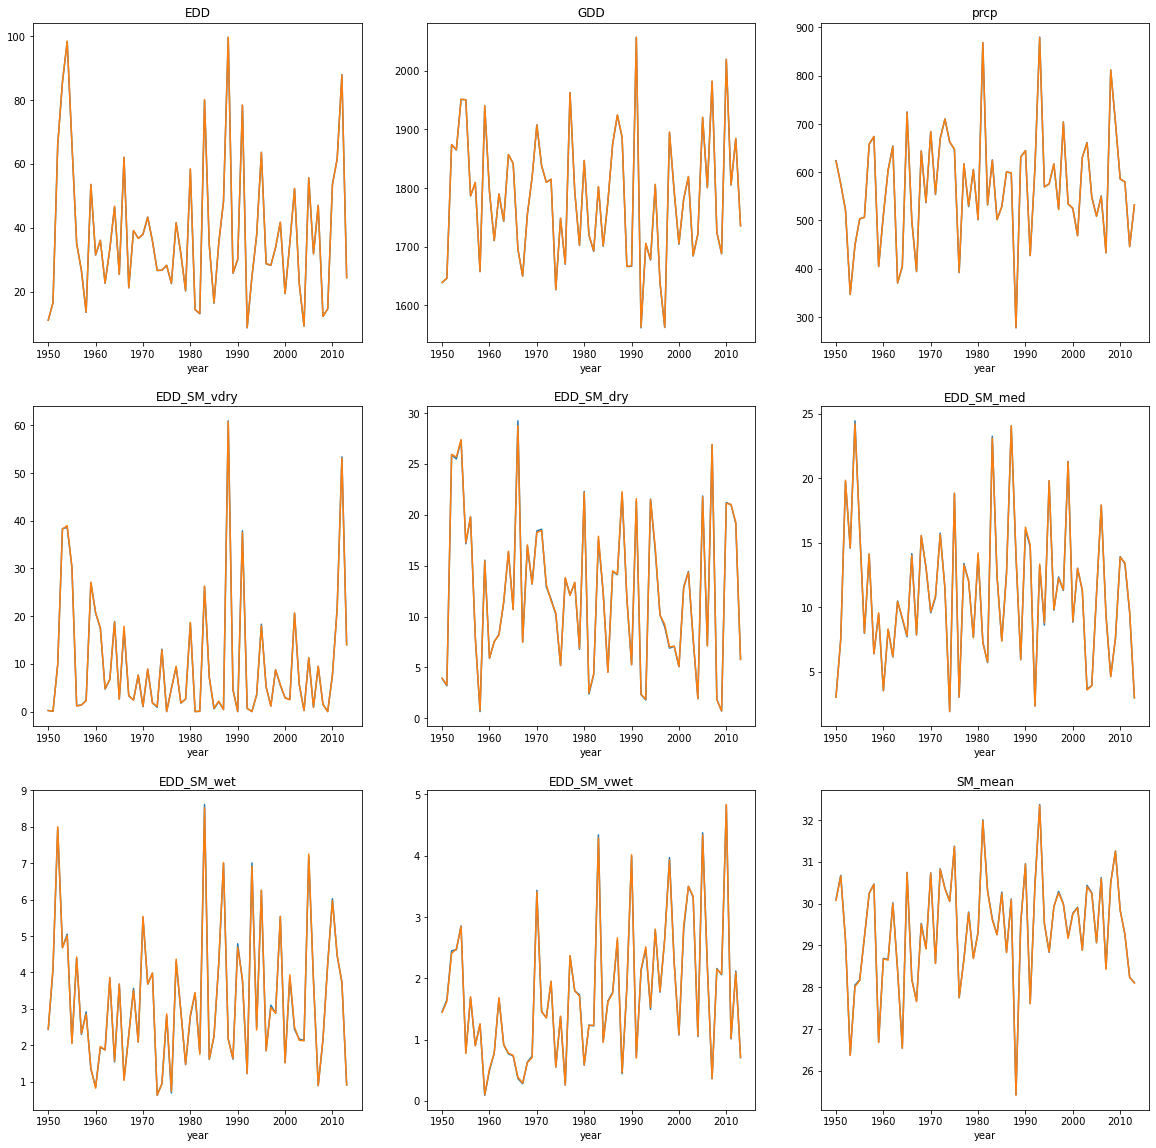

In [36]:
# Check aggregation plots
aggregated = aggregated.set_index(['year'])
aggregated_coarse = aggregated_coarse.set_index(['year'])

var_list = aggregated.columns.drop('fips')

fig, axs = plt.subplots(3,3, figsize=(20,20))
axs = axs.flatten()

for i in range(9):
    var = var_list[i]
    aggregated[var].plot(ax=axs[i])
    aggregated_coarse[var].plot(ax=axs[i])
    axs[i].set_title(var)
    
plt.show()